In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from split import acquire_train_test_data
import warnings
warnings.filterwarnings("ignore")

In [2]:
train,test=acquire_train_test_data()
train,validate=train_test_split(train, train_size=.8, random_state=123, stratify = train.hospital_death)

# Build a function without cross validation

In [3]:
y_train = train['hospital_death']
X_train = train.drop(columns='hospital_death')
y_validate = validate['hospital_death']
X_validate = validate.drop(columns='hospital_death')

In [4]:
dt = DecisionTreeClassifier(max_depth=10,criterion='gini')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [5]:
dt_probs_tra = dt.predict_proba(X_train)
dt_probs_val = dt.predict_proba(X_validate)
dt_probs_tra = dt_probs_tra[:, 1]
dt_probs_val = dt_probs_val[:, 1]
score_tra= roc_auc_score(y_train, dt_probs_tra)
score_val= roc_auc_score(y_validate, dt_probs_val)
score = (score_tra, score_val)

In [6]:
score

(0.8956096034305033, 0.8070256798893025)

# Grid search cross valiation

## Use the grid method to get the auc score.

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
dt= DecisionTreeClassifier()

In [9]:
# keys are names of hyperparams, values are a list of values to try for that hyper parameter
params = {
    'max_depth': range(10, 15),
    'criterion': ['gini', 'entropy']
}

# cv=4 means 4-fold cross-validation, i.e. k = 4
grid = GridSearchCV(dt, params, cv=3,scoring='roc_auc')
grid.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(10, 15)},
             pre_dispat

In [10]:
grid.best_score_

0.7886823132832659

In [11]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 10}

In [12]:
model = grid.best_estimator_
model.score(X_validate, y_validate)

0.9162464222434238

## Use prediction to calculate the auc score

In [13]:
pred_prob = model.predict_proba(X_train)
pred_prob = pred_prob[:, 1]
y_predicted = model.predict(X_train)

In [14]:
roc_auc_score(y_train, pred_prob)

0.8958019442630077

In [15]:
pred_prob = model.predict_proba(X_validate)
pred_prob = pred_prob[:, 1]
roc_auc_score(y_validate, pred_prob)

0.8037187838153732

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
y_test = test['hospital_death']
X_test = test.drop(columns='hospital_death')

In [18]:
model.score(X_test, y_test)

0.9206781878645804

> Here is the problem, the predicted score from gridsearch is not the same as the calculated socre.

So by convention. Just grab the the best paramters and build a model on it.

# Tuning the model with different models and parameters

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [20]:
y_train = train['hospital_death']
X_train = train.drop(columns='hospital_death')
y_validate = validate['hospital_death']
X_validate = validate.drop(columns='hospital_death')

In [21]:
model_params={
    'logistic_regression':{
        'model': LogisticRegression(),
        'params': {
            'C': range(1, 5)
        }
    },
    'DecisionTree':{
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': range(8, 12),
            'criterion': ['gini', 'entropy']
        }
    },
    'RandomFores':{
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[1,5,10]
        }
    }
}

In [22]:
pd.DataFrame(model_params.items())

,0,1
0,logistic_regression,"{'model': LogisticRegression(C=1.0, class_weig..."
1,DecisionTree,{'model': DecisionTreeClassifier(class_weight=...
2,RandomFores,{'model': RandomForestClassifier(bootstrap=Tru...


In [23]:
scores = []
for model_name,mp in model_params.items():
    clf=GridSearchCV(mp['model'],mp['params'],cv=5, scoring='roc_auc')
    clf.fit(X_train, y_train)
    scores.append({
        'model':model_name,
        'best_score': clf.best_score_,
        'best_params':clf.best_params_
    })

In [31]:
scores_df = pd.DataFrame(scores)

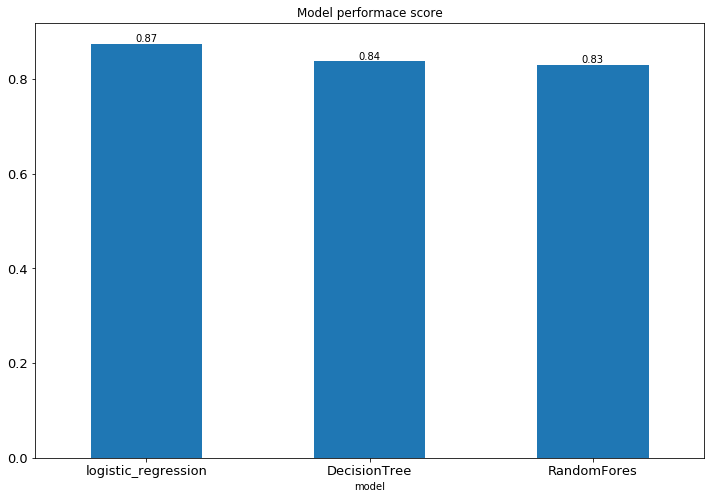

In [56]:
ax = scores_df.set_index('model').best_score.plot.bar(
    figsize=(12,8),
    title='Model performace score',
    fontsize = 13)
ax.set_xticklabels(labels=scores_df.model, rotation=0)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x()+.2, p.get_height() * 1.005))

In [4]:
auc = pd.DataFrame({'ROC_AUC':[.8435,.90989]}, index=['Base_line', 'Best_model'])

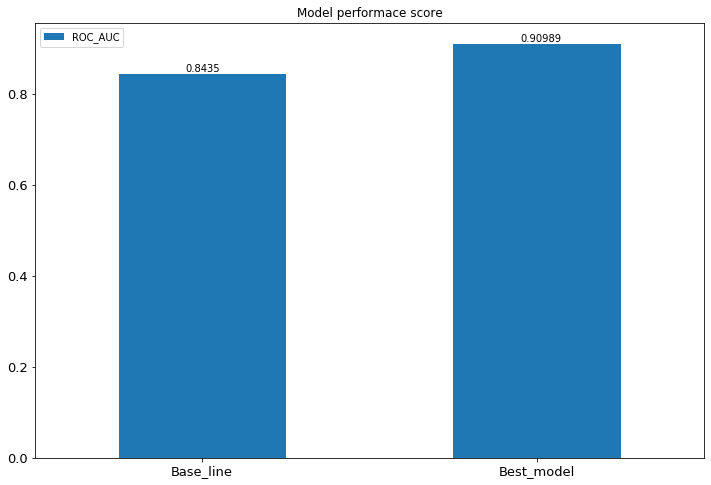

In [15]:
ax =auc.plot.bar(
    figsize=(12,8),
    title='Model performace score',
    fontsize = 13)
ax.set_xticklabels(labels=auc.index, rotation=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+.2, p.get_height() * 1.005))

# Build a model based on best model and params

In [25]:
train,test=acquire_train_test_data()

In [26]:
y_train = train['hospital_death']
X_train = train.drop(columns='hospital_death')
y_test = test['hospital_death']
X_test = test.drop(columns='hospital_death')

In [27]:
train.shape,test.shape

((73370, 134), (18343, 134))

In [28]:
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
lr_probs_tra = lr.predict_proba(X_train)
lr_probs_tes = lr.predict_proba(X_test)
lr_probs_tra = lr_probs_tra[:, 1]
lr_probs_tes = lr_probs_tes[:, 1]
score_tra= roc_auc_score(y_train, lr_probs_tra)
score_tes= roc_auc_score(y_test, lr_probs_tes)
score = (score_tra, score_tes)

In [30]:
score

(0.8776587583093942, 0.8788673510463956)